In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Library Imports

In [ ]:
import scipy.io
import numpy as np
import skimage.io
import skimage.metrics
import scipy.stats
import PIL.Image

import torchvision.transforms as transforms
import torch

import os

###Data Loading

In [ ]:
mat = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/hw5/hw5.mat')

blur_dmos = mat['blur_dmos'][0] # human opinion scores for images 1 to 174 in gblur folder

blur_orgs = mat['blur_orgs'][0] # whether image in gblur folder is the original image

# reference image name in refimgs folder for every distorted image in gblur folder
refnames_blur = []
for i in range(len(mat['refnames_blur'][0])):
    refnames_blur.append(mat['refnames_blur'][0][i][0])

In [ ]:
!pip install lpips


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

###VGG And Alexnet

In [ ]:
import lpips

vgg_net = lpips.LPIPS(net='vgg')
alex_net = lpips.LPIPS(net = 'alex')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 75.3MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 52.0MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:

# Check if CUDA is available
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    vgg_net = lpips.LPIPS(net='vgg').cuda()
    alex_net = lpips.LPIPS(net = 'alex').cuda()
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


### Find all performance metric scores using disorted and refrence images

In [ ]:
# get dictionary of image number vs metric
# example: d_mse[4] = 23.4 -> img5 in g_blur folder has an mse of 23.4 wrt its reference image in refimgs folder
# (note for img_i, corresponding mse would be in d_mse[i-1])

if os.path.exists('d_mse.npy'):
    d_mse = np.load('d_mse.npy',allow_pickle='TRUE').item()
    d_psnr = np.load('d_psnr.npy',allow_pickle='TRUE').item()
    d_ssim = np.load('d_ssim.npy',allow_pickle='TRUE').item()
    d_vgg = np.load('d_vgg.npy',allow_pickle='TRUE').item()
    d_alex = np.load('d_alex.npy',allow_pickle='TRUE').item()
    d_human = np.load('d_human.npy',allow_pickle='TRUE').item()
else:
    # initializing dictionaries
    d_mse = dict()
    d_psnr = dict()
    d_ssim = dict()
    d_vgg = dict()
    d_alex = dict()
    d_human = dict()

    i = 0
    for filename in refnames_blur:
        # reading distorted image from gblur folder
        distorted_img = skimage.io.imread('/content/drive/MyDrive/Colab Notebooks/hw5/gblur/gblur/img'+str(i+1)+'.bmp')
        # reading corresponding reference image from refnames folder
        ref_img = skimage.io.imread('/content/drive/MyDrive/Colab Notebooks/hw5/refimgs/refimgs/'+refnames_blur[i])

        # checking if image from gblur folder is the original. If yes, then skip to next iteration
        og = blur_orgs[i]
        if og == 0:
            human_rating = blur_dmos[i]
            mse = np.average((distorted_img-ref_img)*(distorted_img - ref_img))
            psnr = 100 if mse == 0 else 10 * np.log10(255**2 / mse)
            ssim = skimage.metrics.structural_similarity(distorted_img, ref_img, channel_axis=2)

            distorted_img_tensor = torch.tensor(distorted_img, device=device).permute(2, 0, 1)
            ref_img_tensor = torch.tensor(ref_img, device=device).permute(2, 0, 1)

            vgg = vgg_net.forward(distorted_img_tensor, ref_img_tensor).item()
            alex = alex_net.forward(distorted_img_tensor, ref_img_tensor).item()

            # adding metrics for img_i to respective dictionaries
            d_mse[i] = mse
            d_psnr[i] = psnr
            d_ssim[i] = ssim
            d_vgg[i] = vgg
            d_alex[i] = alex
            d_human[i] = human_rating
        i += 1

    np.save('d_mse.npy', d_mse)
    np.save('d_psnr.npy', d_psnr)
    np.save('d_ssim.npy', d_ssim)
    np.save('d_vgg.npy', d_vgg)
    np.save('d_alex.npy', d_alex)
    np.save('d_human.npy', d_human)

### Spearmen Correlation Coefficient

In [ ]:
# calculating correlation coeffs
mse_vs_human = scipy.stats.spearmanr(list(d_mse.values()), list(d_human.values()))[0]
psnr_vs_human = scipy.stats.spearmanr(list(d_psnr.values()), list(d_human.values()))[0]
ssim_vs_human = scipy.stats.spearmanr(list(d_ssim.values()), list(d_human.values()))[0]
vgg_vs_human = scipy.stats.spearmanr(list(d_vgg.values()), list(d_human.values()))[0]
alex_vs_human = scipy.stats.spearmanr(list(d_alex.values()), list(d_human.values()))[0]

In [ ]:
# print(mse_vs_human, ssim_vs_human, vgg_vs_human)
print(f" Spearmen Rank order correlation coeeficient between dmos and mse is : {mse_vs_human}")
print(f" Spearmen Rank order correlation coeeficient between dmos and psnr is : {psnr_vs_human}")
print(f" Spearmen Rank order correlation coeeficient between dmos and ssim is : {ssim_vs_human}")
print(f" Spearmen Rank order correlation coeeficient between dmos and vgg is : {vgg_vs_human}")
print(f" Spearmen Rank order correlation coeeficient between dmos and alexnet is : {alex_vs_human}")

 Spearmen Rank order correlation coeeficient between dmos and mse is : 0.6607345299952763
 Spearmen Rank order correlation coeeficient between dmos and psnr is : -0.6607345299952763
 Spearmen Rank order correlation coeeficient between dmos and ssim is : -0.9181388757675957
 Spearmen Rank order correlation coeeficient between dmos and vgg is : 0.9465162966461973
 Spearmen Rank order correlation coeeficient between dmos and alexnet is : 0.9014407179971657


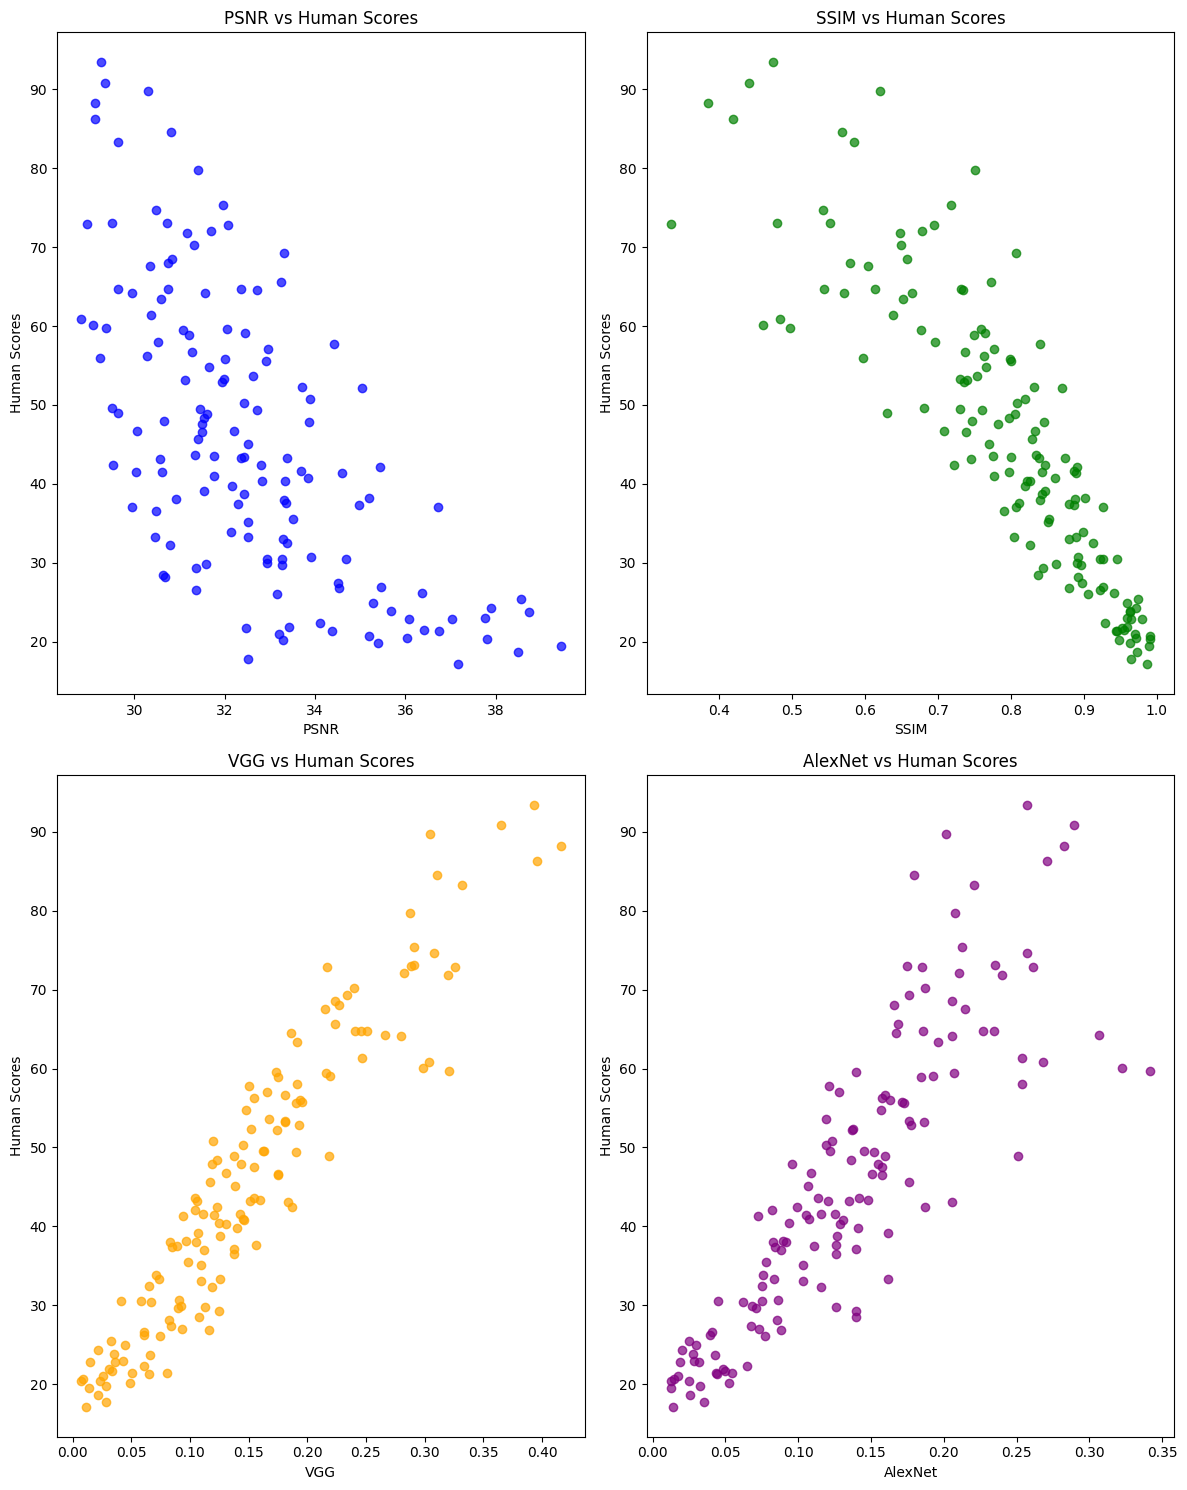

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from the provided code
d_human = np.load('d_human.npy', allow_pickle=True).item()
d_mse = np.load('d_mse.npy', allow_pickle=True).item()
d_psnr = np.load('d_psnr.npy', allow_pickle=True).item()
d_ssim = np.load('d_ssim.npy', allow_pickle=True).item()
d_vgg = np.load('d_vgg.npy', allow_pickle=True).item()
d_alex = np.load('d_alex.npy', allow_pickle=True).item()

# Extract human scores and metric values
human_scores = list(d_human.values())
mse_values = list(d_mse.values())
psnr_values = list(d_psnr.values())
ssim_values = list(d_ssim.values())
vgg_values = list(d_vgg.values())
alex_values = list(d_alex.values())

# Create subplots for each metric
fig, axs = plt.subplots(2, 2, figsize=(12, 15))

# Plot PSNR vs Human Scores
axs[0, 0].scatter(psnr_values, human_scores, color='blue', alpha=0.7)
axs[0, 0].set_title('PSNR vs Human Scores')
axs[0, 0].set_xlabel('PSNR')
axs[0, 0].set_ylabel('Human Scores')

# Plot SSIM vs Human Scores
axs[0, 1].scatter(ssim_values, human_scores, color='green', alpha=0.7)
axs[0, 1].set_title('SSIM vs Human Scores')
axs[0, 1].set_xlabel('SSIM')
axs[0, 1].set_ylabel('Human Scores')

# Plot VGG vs Human Scores
axs[1, 0].scatter(vgg_values, human_scores, color='orange', alpha=0.7)
axs[1, 0].set_title('VGG vs Human Scores')
axs[1, 0].set_xlabel('VGG')
axs[1, 0].set_ylabel('Human Scores')

# Plot AlexNet vs Human Scores
axs[1, 1].scatter(alex_values, human_scores, color='purple', alpha=0.7)
axs[1, 1].set_title('AlexNet vs Human Scores')
axs[1, 1].set_xlabel('AlexNet')
axs[1, 1].set_ylabel('Human Scores')


# Adjust layout and display the plots
plt.tight_layout()
plt.show()
